# Part 13: Find overlapping streets
Added streets could be replicas of existing streets  
michael babb  
2025 10 03

In [1]:
# standard
from itertools import combinations
import os

In [2]:
# external
import geopandas as gpd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# custom
from geo_data_io.fc_df_spatial import write_gdf
import run_constants as rc
from utils import create_city_sector, create_name

In [4]:
# custom
import run_constants as rc
from utils import create_name, generate_street_end_vertices
from geo_data_io.df_operations import hey_what_is_na
from geo_data_io.fc_df_spatial import keep_largest_geometry, write_gdf

# Load the complete street network

In [5]:
# the full network of seattle streets
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S02_SND_COMPLETE_OUT_FILE_NAME)
fpn

'../../../project/seattle_streets/data\\Street_Network_Database_Complete_Revised.gpkg'

In [6]:
c_gdf = gpd.read_file(filename = fpn)

In [7]:
c_gdf.shape

(34378, 39)

In [8]:
c_gdf['snd_id'].unique().shape

(34378,)

In [9]:
# create a graph from the complete street network.
# This wil be used to find and validate the overlapping edges
sc_graph = nx.from_pandas_edgelist(df = c_gdf, source = 'f_intr_id', target = 't_intr_id',edge_attr=True,create_using=nx.MultiGraph, edge_key='snd_id')

# how many instances of parallel edges are there?

In [10]:
def create_node_pair_hash_id(row):
    # hash the sorted sn_id, en_id pair
    sn_id = row['f_intr_id']
    en_id = row['t_intr_id']    
    node_id_list = [sn_id, en_id]
    node_id_list.sort()    
    node_pair_hash = hash(tuple(node_id_list))
    return node_pair_hash
    
c_gdf['node_pair_hash'] = c_gdf.apply(func = create_node_pair_hash_id, axis = 1)


In [11]:
# parallel edges
pe_c_gdf = c_gdf['node_pair_hash'].value_counts().to_frame()
pe_c_gdf.loc[pe_c_gdf['count'] > 1, ].shape

(132, 1)

# load the added streets

In [12]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S05_MISSING_IN_FILE_NAME)
fpn

'../../../project/seattle_streets/data\\missing_segments_v2.gpkg'

In [13]:
gdf = gpd.read_file(filename = fpn)

In [14]:
gdf.dtypes

snd_id                      int64
ord_street_name            object
ord_street_type            object
ord_stname_type            object
ord_stname_concat          object
ord_stname_unique          object
ord_stname_type_group      object
ord_street_type_rank       object
snd_group                   int64
group_id                    int64
city_sector                object
city_sector_group          object
street_status               int64
sn_id                       int64
en_id                       int64
dist                      float64
dist_miles                float64
geometry                 geometry
dtype: object

In [15]:
def get_snd_id(row):

    # assigned edge id
    gen_snd_id = row['snd_id']
    # starting node
    sn_id = row['sn_id']
    # ending node
    en_id = row['en_id']    

    # create a hash id
    node_pair_hash = hash(tuple(sorted([sn_id, en_id])))

    # track the number of matches and type of match
    n_edge_matches = -1
    edge_match_outcome = -1    
    
    # check if the edge is existing
    is_existing = sc_graph.has_edge(u = sn_id, v = en_id)
    if is_existing:
        # there is an existing edge between sn_id and en_id
        
        # get the edge data
        edge_data = sc_graph.get_edge_data(u = sn_id, v = en_id)
        # number of edges
        n_edge_matches = len(edge_data)

        if gen_snd_id in edge_data:            
            # the edge exists and has the same id as an existing street
            snd_id = gen_snd_id
            if n_edge_matches == 1 :
                edge_match_outcome = 0
                # there is one single existing edge - these are existing streets
                # this is the most common
            else:
                edge_match_outcome = 1
                # there are multiple existing edges, but we only need to track one
                # rare outcome
        else:
            # the edge exists, but has a different id                        
            # these are the added, overlapping streets
            overlapping_snd_id_list = list(edge_data.keys())            
            if len(overlapping_snd_id_list) == 1:                
                snd_id = overlapping_snd_id_list[0]
                edge_match_outcome = 2
                # added street with a single overlapping edge
            else: 
                # multiple overlapping edges, we only need
                # sort based on segment_type and snd_id to ensure repeatability
                # sorting also helps ensure that streets are chosen over walkways or rail                
                temp_c_gdf = c_gdf.loc[c_gdf['snd_id'].isin(overlapping_snd_id_list), :].sort_values(by = ['segment_type', 'snd_id'])
                snd_id = temp_c_gdf['snd_id'].iloc[0]
                edge_match_outcome = 3
                # added street with multiple overlapping edges to choose from
                # this is the rarest possibility
            
                # the sum of edges marked 2 and 3 produces the total count of overlapping edges
    else:
        snd_id = gen_snd_id
        n_edge_matches = 0
        edge_match_outcome = 4
        # a genuine new street, no overlaps
    
    return [gen_snd_id, snd_id, node_pair_hash, n_edge_matches, edge_match_outcome]
    
snd_id = gdf.apply(func = get_snd_id, axis = 1).tolist()
col_names = ['gen_snd_id', 'ex_snd_id', 'node_pair_hash', 'n_matches', 'edge_match_outcome']
snd_df = pd.DataFrame(data = snd_id, columns = col_names)
test_gdf = pd.merge(left = gdf, right = snd_df,  left_on = 'snd_id', right_on='gen_snd_id')
test_gdf.shape

(29780, 23)

In [16]:
snd_df.head()

,gen_snd_id,ex_snd_id,node_pair_hash,n_matches,edge_match_outcome
0,4787,4787,1742632130526754415,1,0
1,4802,4802,5541996999238381137,1,0
2,4864,4864,-7375905431718567330,1,0
3,49871,49871,-7366121494389088306,1,0
4,65537,65537,-2157650562141655519,0,4


In [17]:
test_gdf['n_matches'].value_counts()

n_matches
1    26451
0     3199
2       80
3       50
Name: count, dtype: int64

In [18]:
test_gdf['edge_match_outcome'].value_counts()

edge_match_outcome
0    25628
4     3199
2      823
1      128
3        2
Name: count, dtype: int64

In [19]:
gdf = test_gdf.copy()

In [20]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'gen_snd_id', 'ex_snd_id', 'node_pair_hash',
       'n_matches', 'edge_match_outcome'],
      dtype='object')

In [21]:
gdf['n_matches'].value_counts()

n_matches
1    26451
0     3199
2       80
3       50
Name: count, dtype: int64

In [22]:
gdf['edge_match_outcome'].value_counts()

edge_match_outcome
0    25628
4     3199
2      823
1      128
3        2
Name: count, dtype: int64

In [23]:
# determine which columns have matching snd values
col_names = ['snd_id', 'gen_snd_id', 'ex_snd_id']
for s_cn, t_cn in combinations(col_names, r = 2):
    print(s_cn, t_cn)
    print((gdf[s_cn] != gdf[t_cn]).value_counts())

snd_id gen_snd_id
False    29780
Name: count, dtype: int64
snd_id ex_snd_id
False    28955
True       825
Name: count, dtype: int64
gen_snd_id ex_snd_id
False    28955
True       825
Name: count, dtype: int64


In [24]:
# snd_id and gen_snd_id are the same. 
# Let's drop the snd_id
gdf = gdf.drop(labels = ['snd_id'], axis = 1)

In [25]:
# flag where gen_snd_id != ex_snd_id
gdf['existing_segment'] = (gdf['gen_snd_id'] != gdf['ex_snd_id']).astype(int)

In [26]:
gdf['existing_segment'].sum()

np.int64(825)

In [27]:
gdf['n_segments'] = int(1)

In [28]:
# do a pivot!
pv_df = pd.pivot_table(data = gdf, 
                       values = 'n_segments',
                       index = 'street_status',
                       columns = 'existing_segment',
                       aggfunc='sum',
                       fill_value = 0,
                       margins = True).reset_index()
pv_df.columns = ['street_status', 'overlap_existing', 'is_existing', 'total']
pv_df.head()

,street_status,overlap_existing,is_existing,total
0,0,3825,0,3825
1,1,21931,0,21931
2,2,2806,808,3614
3,3,393,17,410
4,All,28955,825,29780


# simple stats about the added streets

In [29]:
gdf['street_status_desc'] = gdf['street_status'].map(rc.street_status_dict)

In [30]:
gdf['street_status_reclass'] = gdf['street_status'].astype(str) + '_' + gdf['existing_segment'].astype(str)

In [31]:
gdf['street_status_reclass'].value_counts()

street_status_reclass
1_0    21931
0_0     3825
2_0     2806
2_1      808
3_0      393
3_1       17
Name: count, dtype: int64

In [32]:
rc.street_status_reclass_dict

{'0_0': 'continuous_street',
 '1_0': 'discontinuous_street',
 '2_0': 'added_street: within-sector, not existing',
 '2_1': 'added_street: within-sector, existing',
 '3_0': 'added_street: cross-sector, not existing',
 '3_1': 'added_street: cross-sector, existing'}

In [33]:
gdf['street_status_reclass_desc'] = gdf['street_status_reclass'].map(rc.street_status_reclass_dict)

In [34]:
gdf['street_status_reclass_desc'].value_counts()

street_status_reclass_desc
discontinuous_street                         21931
continuous_street                             3825
added_street: within-sector, not existing     2806
added_street: within-sector, existing          808
added_street: cross-sector, not existing       393
added_street: cross-sector, existing            17
Name: count, dtype: int64

In [35]:
gdf.columns

Index(['ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'gen_snd_id', 'ex_snd_id', 'node_pair_hash',
       'n_matches', 'edge_match_outcome', 'existing_segment', 'n_segments',
       'street_status_desc', 'street_status_reclass',
       'street_status_reclass_desc'],
      dtype='object')

In [36]:
# sum of miles by street status
col_names = ['street_status_reclass', 'dist_miles', 'n_segments']
ss_rc_df = gdf[col_names].groupby(col_names[:-2]).agg(total_miles = ('dist_miles', 'sum'))
ss_rc_df['total_miles'] = ss_rc_df['total_miles'].round(0).astype(int)
ss_rc_df

,total_miles
street_status_reclass,
0_0,313
1_0,1578
2_0,809
2_1,22
3_0,823
3_1,1


In [37]:
ss_count_df = gdf['street_status'].value_counts().to_frame(name = 'n_segments').reset_index()

# plot of differences in within-sector connected streets

In [38]:
# compute logs of distance
gdf['dist_miles_log'] = np.log10(gdf['dist_miles'])

In [39]:
##
# stack the original and the reclassified streets - this is used to generate the histograms
##
df_list = []

# the original classification
col_names = ['ord_stname_concat', 'dist', 'dist_miles', 'dist_miles_log', 'street_status', 'street_status_desc']
tdf = gdf.loc[gdf['street_status'] == 2, col_names]
tdf['street_status'] = gdf['street_status'].astype(str)
df_list.append(tdf)

# the reclassified streets highlighting overlaps
col_names = ['ord_stname_concat', 'dist', 'dist_miles', 'dist_miles_log', 'street_status_reclass', 'street_status_reclass_desc']
tdf = gdf.loc[gdf['street_status'] == 2, col_names]
col_names = ['ord_stname_concat', 'dist', 'dist_miles', 'dist_miles_log', 'street_status', 'street_status_desc']
tdf.columns = col_names 
df_list.append(tdf)
tdf = pd.concat(objs = df_list, axis = 0)

In [40]:
##
# CREATE A DATAFRAME THAT HOLDS ALL OF THE DESCRIPTIVE STATISTICS AND PLOTTING OPTIONS
##

In [41]:
# ds 1: averages
# ds 2: added segments by type
# ds 3: unique roads

In [42]:
tdf['n_segments'] = int(1)

In [43]:
##
# Descriptive Statistic 01: average segment length and positioning for each group
##
col_names = ['street_status', 'street_status_desc', 'dist_miles', 'n_segments']
ds_df = tdf[col_names].groupby(col_names[:-2]).agg(avg_dist_miles = ('dist_miles', 'mean'),
                                                   total_miles = ('dist_miles', 'sum'),
                                                   n_segments = ('n_segments', 'sum')).reset_index()
ds_df['avg_dist_miles_log'] = np.log10(ds_df['avg_dist_miles'])
ds_df['avg_dist'] = ds_df['avg_dist_miles'] * 5280
#ds_df['color'] = ['#000000', '#ca0020', '#b88b0b'] # these colors are used throughout
ds_df['color'] = ['#000000', '#ca0020', '#ff7f00'] # these colors are used throughout
ds_df['avg_text'] = ['0.23 mi (avg.)', '0.29 mi (avg.)',  '145 ft (avg.)']
ds_df['avg_text_ha'] = ['right', 'left', 'center']
ds_df['avg_text_x_pos'] = ds_df['avg_dist_miles_log']
# the horizontal position is created from the distance in miles and the text jitter


In [44]:
ds_df

,street_status,street_status_desc,avg_dist_miles,total_miles,n_segments,avg_dist_miles_log,avg_dist,color,avg_text,avg_text_ha,avg_text_x_pos
0,2,added_street: within-sector,0.230051,831.403361,3614,-0.638176,1214.667887,#000000,0.23 mi (avg.),right,-0.638176
1,2_0,"added_street: within-sector, not existing",0.288409,809.275928,2806,-0.539991,1522.800035,#ca0020,0.29 mi (avg.),left,-0.539991
2,2_1,"added_street: within-sector, existing",0.027385,22.127433,808,-1.562480,144.595106,#ff7f00,145 ft (avg.),center,-1.562480


In [45]:
##
# Descriptive Statistic 02: what roads have only new segments and/or only existing segment?
##
# pivot to get membership by street type
ss_df = pd.pivot_table(data = gdf, index = ['ord_stname_concat'],
                 columns = ['street_status_reclass'],
                 values = ['n_segments'],aggfunc = 'sum', fill_value = 0)
# new columns
ss_df.columns = ['continuous', 'discontinuous', 'asws_new', 'asws_ex', 'ascs_new', 'ascs_ex']

# rescale to 1 if GT 1
ss_df = ss_df.map(func = lambda x: 1 if x > 1 else x)
def unpack_it(row):
    return '_'.join([str(rv) for rv in row.to_numpy()])

ss_df['combined_class'] = ss_df.apply(unpack_it, axis = 1)

# these are the street combos of interest
voi = ['0_1_1_0_0_0', '0_1_1_1_0_0', '0_1_0_1_0_0']
ss_df = ss_df.loc[ss_df['combined_class'].isin(voi), 'combined_class'].value_counts().to_frame(name = 'n_unique_roads').reset_index()

# add street status for joining
ss_df['street_status'] = ['2_0', '2', '2_1']
ds_df = pd.merge(left = ds_df, right = ss_df)

# Descriptive Statistic 02: segment status and histogram 
ds_df['seg_stat_desc'] =  ['added', 'new', 'existing']
ds_df['seg_stat_alpha'] =  [0.2, 0.8, 0.8]
ds_df['seg_stat_xy_text'] =  [(-3.15, 160), (-3.15, 145), (-3.15, 130)]
ds_df['foreground_color'] =  ['white', 'white', 'white']

In [46]:
ds_df.head()

,street_status,street_status_desc,avg_dist_miles,total_miles,n_segments,avg_dist_miles_log,avg_dist,color,avg_text,avg_text_ha,avg_text_x_pos,combined_class,n_unique_roads,seg_stat_desc,seg_stat_alpha,seg_stat_xy_text,foreground_color
0,2,added_street: within-sector,0.230051,831.403361,3614,-0.638176,1214.667887,#000000,0.23 mi (avg.),right,-0.638176,0_1_1_1_0_0,399,added,0.2,"(-3.15, 160)",white
1,2_0,"added_street: within-sector, not existing",0.288409,809.275928,2806,-0.539991,1522.800035,#ca0020,0.29 mi (avg.),left,-0.539991,0_1_1_0_0_0,590,new,0.8,"(-3.15, 145)",white
2,2_1,"added_street: within-sector, existing",0.027385,22.127433,808,-1.562480,144.595106,#ff7f00,145 ft (avg.),center,-1.562480,0_1_0_1_0_0,112,existing,0.8,"(-3.15, 130)",white


In [47]:
# Descriptive Statistic 03: unique roads
ds_df['ur_desc'] = ['new and overlapping segments', 'only new segments',  'only overlapping segments']
ds_df['ur_xy_text'] = [(-3.15, 100), (-3.15, 85), (-3.15, 70)]

In [48]:
ss = '2'
ds_dict = ds_df.loc[ds_df['street_status'] == ss, :].to_dict(orient = 'records')[0]
ds_dict

{'street_status': '2',
 'street_status_desc': 'added_street: within-sector',
 'avg_dist_miles': 0.23005073625172942,
 'total_miles': 831.4033608137502,
 'n_segments': 3614,
 'avg_dist_miles_log': -0.6381763724858979,
 'avg_dist': 1214.6678874091313,
 'color': '#000000',
 'avg_text': '0.23 mi (avg.)',
 'avg_text_ha': 'right',
 'avg_text_x_pos': -0.6381763724858979,
 'combined_class': '0_1_1_1_0_0',
 'n_unique_roads': 399,
 'seg_stat_desc': 'added',
 'seg_stat_alpha': 0.2,
 'seg_stat_xy_text': (-3.15, 160),
 'foreground_color': 'white',
 'ur_desc': 'new and overlapping segments',
 'ur_xy_text': (-3.15, 100)}

2
2_0
2_1
..\graphics\histogram_ws_ALL_streets_overlapping.png


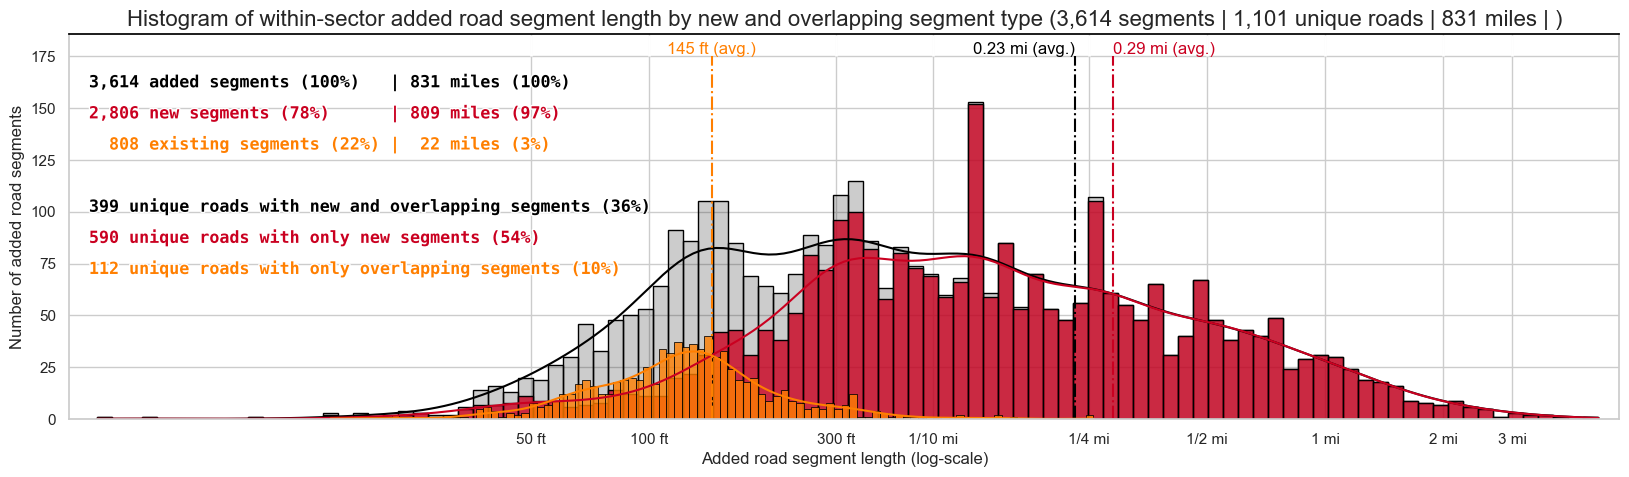

In [49]:
# start your plots
# top to bottom
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 185.6)
ax.set_xlim(-3.2, .75)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

# y ticks
y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

ax.set_yticks(ticks = y_ticks)
ax.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# x tick positions - need to log transform to match the inputs
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# x tick labels
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '3 mi']

ax.set_xticks(ticks = x_ticks)
ax.set_xticklabels(labels = x_tick_label_text, rotation=0)

# add separate histograms for each group.
# This way we can control the alpha transparency for each histogram
for ss in tdf['street_status'].unique():
    print(ss)

    # place the descriptive stats and plotting options into a dictionary
    ds_dict = ds_df.loc[ds_df['street_status'] == ss, :].to_dict(orient = 'records')[0]
        
    # current working df
    adf = tdf.loc[tdf['street_status'] == ss, :]
    
    # total segments
    total_segments = ds_df.loc[ds_df['street_status'] == '2', 'n_segments'].iloc[0]
    ss_segments = adf.shape[0]
    per_segments = ss_segments / total_segments 
    total_segments = f"{total_segments:,}"
    ss_segments = f"{ss_segments:,}"
    per_segments = f"{per_segments:.0%}"

    # total miles
    total_miles = tdf.loc[tdf['street_status'] == '2', 'dist_miles'].sum()
    ss_miles = int(round(ds_dict['total_miles'], 0))
    per_miles = ss_miles / total_miles
    total_miles = f"{int(total_miles)}"
    ss_miles = f"{ss_miles:,}"    
    per_miles = f"{per_miles:.0%}"    
        
    # total unique roads
    total_unique_roads = ds_df['n_unique_roads'].sum()
    n_unique_roads = ds_dict['n_unique_roads']
    per_unique_roads = n_unique_roads / total_unique_roads
    total_unique_roads = f"{total_unique_roads:,}"
    n_unique_roads = f"{n_unique_roads:,}"
    per_unique_roads = f"{per_unique_roads:.0%}"
            
    # create a color palette of the form 'data_category':'color
    color_palette = {ss:ds_dict['color']}    

    # add the histogram
    ax1 = sns.histplot(
        data=adf,
        x="dist_miles_log",
        hue="street_status",
        palette=color_palette,
        element='bars',
        multiple = 'layer',
        bins = 100,
        edgecolor = 'black',
        alpha = ds_dict['seg_stat_alpha'],
        legend=None,
        kde = True
    )

    ##
    # DESCRIPTIVE STATISTICS 1: Average segment length
    ##
    # add vertical lines at some descriptive statistics points
    ax.vlines(x = ds_dict['avg_dist_miles_log'], ymin = 0, ymax = 175, color = ds_dict['color'], linestyles = 'dashdot')

    # add text for the descriptive stats    
    ax.text(x = ds_dict['avg_text_x_pos'], y = 176, s = ds_dict['avg_text'], horizontalalignment = ds_dict['avg_text_ha'], color = ds_dict['color'])

    ##
    # DESCRIPTIVE STATISTICS 2: Segment status
    ##
    # add the text describing segments the mileage
    desc_text = f"{ss_segments.rjust(5)} {ds_dict['seg_stat_desc']} segments ({per_segments})".ljust(30) +  f"| {ss_miles.rjust(3)} miles ({per_miles})"
            
    txt = ax.annotate(text = desc_text, xy = ds_dict['seg_stat_xy_text'],
                color = ds_dict['color'], fontsize = 12,
                fontweight = 'bold', fontstretch = 'extra-expanded', fontfamily = 'monospace')
    
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground=ds_dict['foreground_color']),
        path_effects.Normal()
        ])
    
    ##
    # DESCRIPTIVE STATISTICS 3: Unique road counts
    ##
    # add some text with the road counts

    # add the text describing the mileage
    desc_text = f"{n_unique_roads} unique roads with {ds_dict['ur_desc']} ({per_unique_roads})"
            
    txt = ax.annotate(text = desc_text, xy = ds_dict['ur_xy_text'],
                color = ds_dict['color'], fontsize = 12,
                fontweight = 'bold', fontstretch = 'extra-expanded', fontfamily = 'monospace')
    
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ])    

# white out the top portion of the ticks
for xt in x_ticks:
    ax.vlines(x = xt, ymin = 175, ymax = 185, color = 'white', linestyles = 'solid', linewidth = 2)

##
# BUILD THE TITLE
##
asws_df = gdf.loc[gdf['street_status'] == 2, ]

# segments
n_added = asws_df.shape[0]
n_added =  f"{n_added:,}"

tot_miles = asws_df['dist_miles'].sum()
tot_miles = f"{int(round(tot_miles, 0)):,}"

unique_roads = asws_df['ord_stname_concat'].unique().shape[0]
unique_roads = f"{unique_roads:,}"

my_title = f"Histogram of within-sector added road segment length by new and overlapping segment type ({n_added} segments | {unique_roads} unique roads | {tot_miles} miles | )"
plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Added road segment length (log-scale)')
plt.ylabel(ylabel = "Number of added road segments")

output_file_name = '..\\graphics\\histogram_ws_ALL_streets_overlapping.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
ax.get_figure().savefig(fname = output_file_name)

# what are the existing segments - what are those features like?

In [50]:
# okay, let's do some crosstabs to get the overall picture
col_names = ['street_status_reclass', 'street_status_reclass_desc', 'dist_miles']
outcome = gdf[col_names].groupby(col_names[:-1]).describe()
outcome

dist_miles  \
                                                                     count   
street_status_reclass street_status_reclass_desc                             
0_0                   continuous_street                             3825.0   
1_0                   discontinuous_street                         21931.0   
2_0                   added_street: within-sector, not existing     2806.0   
2_1                   added_street: within-sector, existing          808.0   
3_0                   added_street: cross-sector, not existing       393.0   
3_1                   added_street: cross-sector, existing            17.0   

                                                                           \
                                                                     mean   
street_status_reclass street_status_reclass_desc                            
0_0                   continuous_street                          0.081753   
1_0                   discontinuous_street                       0.071953   
2_0                   added_street: within-sector, not existing  0.288409   
2_1                   added_street: within-sector, existing      0.027385   
3_0                   added_street: cross-sector, not existing   2.094195   
3_1                   added_street: cross-sector, existing       0.041748   

                                                                           \
                                                                      std   
street_status_reclass street_status_reclass_desc                            
0_0                   continuous_street                          0.068245   
1_0                   discontinuous_street                       0.043731   
2_0                   added_street: within-sector, not existing  0.416748   
2_1                   added_street: within-sector, existing      0.020434   
3_0                   added_street: cross-sector, not existing   2.298184   
3_1                   added_street: cross-sector, existing       0.069082   

                                                                           \
                                                                      min   
street_status_reclass street_status_reclass_desc                            
0_0                   continuous_street                          0.003287   
1_0                   discontinuous_street                       0.001515   
2_0                   added_street: within-sector, not existing  0.000744   
2_1                   added_street: within-sector, existing      0.002922   
3_0                   added_street: cross-sector, not existing   0.010212   
3_1                   added_street: cross-sector, existing       0.007820   

                                                                           \
                                                                      25%   
street_status_reclass street_status_reclass_desc                            
0_0                   continuous_street                          0.044034   
1_0                   discontinuous_street                       0.048485   
2_0                   added_street: within-sector, not existing  0.060706   
2_1                   added_street: within-sector, existing      0.016892   
3_0                   added_street: cross-sector, not existing   0.502107   
3_1                   added_street: cross-sector, existing       0.017979   

                                                                           \
                                                                      50%   
street_status_reclass street_status_reclass_desc                            
0_0                   continuous_street                          0.063152   
1_0                   discontinuous_street                       0.060984   
2_0                   added_street: within-sector, not existing  0.128373   
2_1                   added_street: within-sector, existing      0.023457   
3_0                   added_street: cross-sect

In [51]:
gdf['street_status_reclass'].value_counts()

street_status_reclass
1_0    21931
0_0     3825
2_0     2806
2_1      808
3_0      393
3_1       17
Name: count, dtype: int64

In [52]:
col_names = ['snd_id', 'segment_type', 'snd_feacode']

In [53]:
gdf = pd.merge(left = gdf, right = c_gdf[col_names], left_on = 'ex_snd_id', right_on = 'snd_id', how = 'left')

In [54]:
gdf.loc[gdf['snd_id'].isna(), 'snd_id'] = gdf.loc[gdf['snd_id'].isna(), 'gen_snd_id']

In [55]:
for cn in ['segment_type', 'snd_feacode']:
    gdf[cn] = gdf[cn].fillna(-1).astype(int)

In [56]:
gdf.columns

Index(['ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'gen_snd_id', 'ex_snd_id', 'node_pair_hash',
       'n_matches', 'edge_match_outcome', 'existing_segment', 'n_segments',
       'street_status_desc', 'street_status_reclass',
       'street_status_reclass_desc', 'dist_miles_log', 'snd_id',
       'segment_type', 'snd_feacode'],
      dtype='object')

In [57]:
gdf['street_status_reclass'].value_counts()

street_status_reclass
1_0    21931
0_0     3825
2_0     2806
2_1      808
3_0      393
3_1       17
Name: count, dtype: int64

In [58]:
gdf['dist_miles_rank'] = gdf.groupby('street_status')['dist_miles'].rank(method = 'dense', ascending = False)
gdf.loc[gdf['dist_miles_rank'] == 1, ['street_status', 'ord_stname_concat', 'dist_miles'] ].head()
    

,street_status,ord_stname_concat,dist_miles
12502,3,62ND AVE NE_S,11.127778
14163,2,7TH PL S,4.973674
16388,0,ARBORETUM DR E,0.974518
29268,1,WEST MARGINAL WAY SW,0.895253


In [59]:
sorted(gdf.loc[(gdf['street_status'] == 2) & (gdf['dist_miles_rank'] <= 10)
        , 'ord_stname_concat'].tolist())

['11TH AVE S',
 '12TH AVE SW',
 '33RD AVE SW',
 '51ST AVE SW',
 '7TH PL S',
 '9TH AVE S',
 'S 105TH ST',
 'S 106TH ST',
 'S 112TH ST',
 'S 116TH ST']

In [60]:
gdf.loc[gdf['dist_miles'] == gdf['dist_miles'].min(), ]

,ord_street_name,ord_street_type,ord_stname_type,ord_stname_concat,ord_stname_unique,ord_stname_type_group,ord_street_type_rank,snd_group,group_id,city_sector,...,existing_segment,n_segments,street_status_desc,street_status_reclass,street_status_reclass_desc,dist_miles_log,snd_id,segment_type,snd_feacode,dist_miles_rank
18423,CLOVERDALE,ST,CLOVERDALE ST,SW CLOVERDALE ST,SW CLOVERDALE ST,CLOVERDALE ST SW_S,10_ST,5,1,SW,...,0,1,added_street: within-sector,2_0,"added_street: within-sector, not existing",-3.128428,68281.0,-1,-1,3597.0


In [70]:
gdf.columns

Index(['ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'gen_snd_id', 'ex_snd_id', 'node_pair_hash',
       'n_matches', 'edge_match_outcome', 'existing_segment', 'n_segments',
       'street_status_desc', 'street_status_reclass',
       'street_status_reclass_desc', 'dist_miles_log', 'snd_id',
       'segment_type', 'snd_feacode', 'dist_miles_rank'],
      dtype='object')

In [ ]:
# how many roads?
ss = 'street_status_reclass'
col_names = [ss, 'ord_stname_concat', 'n_segments', 'dist_miles', 'dist']
stat_check_df = gdf[col_names].groupby(col_names[:2]).agg(n_segments = ('n_segments', 'sum'),                                                           
                                                           dist_miles = ('dist_miles', 'sum'),
                                                           dist_feet = ('dist', 'sum')).reset_index()
print(stat_check_df.loc[stat_check_df[ss] == '2_0', ].sort_values(by = 'n_segments', ascending = False).head())
print(stat_check_df.loc[stat_check_df[ss] == '2_0', ].sort_values(by = 'dist_miles', ascending = False).head())

# do another aggregation to count the number of roads
stat_check_df['n_roads'] = int(1)
col_names = [ss, 'n_roads', 'n_segments', 'dist_miles', 'dist_feet']
stat_check_df = stat_check_df[col_names].groupby(col_names[:1]).agg(n_roads = ('n_roads', 'sum'),
                                                           n_segments = ('n_segments', 'sum'),                                                           
                                                           dist_miles = ('dist_miles', 'sum'),
                                                           dist_feet = ('dist_feet', 'sum')).reset_index()
stat_check_df['avg_added_segment'] = stat_check_df['n_segments'] / stat_check_df['n_roads']
stat_check_df['avg_added_length'] = stat_check_df['dist_miles'] / stat_check_df['n_segments']
stat_check_df['avg_added_length_feet'] = stat_check_df['avg_added_length'] * 5280

stat_check_df['dist_miles'] = stat_check_df['dist_miles'].round(0).astype(int)
stat_check_df['avg_added_length_feet'] = stat_check_df['avg_added_length_feet'].round(0).astype(int)


display(stat_check_df)

     street_status_reclass ord_stname_concat  n_segments  dist_miles  \
2584                   2_0        30TH AVE S          11    1.687962   
2614                   2_0        35TH AVE S          10    2.514357   
2579                   2_0        2ND AVE NE          10    2.807802   
3109                   2_0    PALATINE AVE N          10    1.927207   
2667                   2_0        45TH AVE S          10    1.900834   

         dist_feet  
2584   8912.438636  
2614  13275.805959  
2579  14825.193253  
3109  10175.654105  
2667  10036.401443  
     street_status_reclass ord_stname_concat  n_segments  dist_miles  \
2778                   2_0         9TH AVE S           3    5.704713   
2761                   2_0          7TH PL S           1    4.973674   
2465                   2_0        11TH AVE S           2    4.577084   
2457                   2_0        10TH AVE S           7    4.535400   
2510                   2_0        19TH AVE S           6    4.501965   

        

,street_status_reclass,n_roads,n_segments,dist_miles,dist_feet,avg_added_segment,avg_added_length,avg_added_length_feet
0,0_0,1150,3825,313,1.651078e+06,3.326087,0.081753,432
1,1_0,1305,21931,1578,8.331892e+06,16.805364,0.071953,380
2,2_0,989,2806,809,4.272977e+06,2.837209,0.288409,1523
3,2_1,511,808,22,1.168328e+05,1.581213,0.027385,145
4,3_0,304,393,823,4.345539e+06,1.292763,2.094195,11057
5,3_1,17,17,1,3.747279e+03,1.000000,0.041748,220


In [74]:
# break this out by ord_stname_concat
g0 = '2_0'
g1 = '2_1'

s0 = set(gdf.loc[gdf['street_status_reclass'] == g0, 'ord_stname_concat'].tolist())
s1 = set(gdf.loc[gdf['street_status_reclass'] == g1, 'ord_stname_concat'].tolist())
# the intersection
s2 = s0.intersection(s1)
# update
s0 = s0 - s2
s1 = s1 - s2

print(len(s0), len(s1), len(s2)) 
print(len(s0) + len(s2))
print(len(s1) + len(s2))
print(len(s0) + len(s1) + len(s2))


g0 = '3_0'
g1 = '3_1'

s0 = set(gdf.loc[gdf['street_status_reclass'] == g0, 'ord_stname_concat'].tolist())
s1 = set(gdf.loc[gdf['street_status_reclass'] == g1, 'ord_stname_concat'].tolist())
# the intersection
s2 = s0.intersection(s1)
# update
s0 = s0 - s2
s1 = s1 - s2

print(len(s0), len(s1), len(s2)) 
print(len(s0) + len(s2))
print(len(s1) + len(s2))
print(len(s0) + len(s1) + len(s2))



590 112 399
989
511
1101
296 9 8
304
17
313


In [75]:
# can we generate summary status by street_status
ss_df_list = []
ss_df = gdf.groupby('street_status_reclass')['dist_miles'].describe()
ss_df = ss_df.round(2)
ss_df['units'] = 'miles'
ss_df_list.append(ss_df)
ss_df = gdf.groupby('street_status_reclass')['dist'].describe()
ss_df = ss_df.round(0)
ss_df['units'] = 'feet'
ss_df_list.append(ss_df)
ss_df = pd.concat(objs = ss_df_list, axis = 0)
display(ss_df)


,count,mean,std,min,25%,50%,75%,max,units
street_status_reclass,,,,,,,,,
0_0,3825.0,0.08,0.07,0.00,0.04,0.06,0.10,0.97,miles
1_0,21931.0,0.07,0.04,0.00,0.05,0.06,0.09,0.90,miles
2_0,2806.0,0.29,0.42,0.00,0.06,0.13,0.33,4.97,miles
2_1,808.0,0.03,0.02,0.00,0.02,0.02,0.03,0.26,miles
3_0,393.0,2.09,2.30,0.01,0.50,1.20,2.72,11.13,miles
3_1,17.0,0.04,0.07,0.01,0.02,0.03,0.03,0.31,miles
0_0,3825.0,432.00,360.00,17.00,232.00,333.00,532.00,5145.00,feet
1_0,21931.0,380.00,231.00,8.00,256.00,322.00,480.00,4727.00,feet
2_0,2806.0,1523.00,2200.00,4.00,321.00,678.00,1768.00,26261.00,feet


In [ ]:
# let's check the double counted streets!
multi_segments = gdf['node_pair_hash'].value_counts().to_frame(name = 'n_segments').reset_index(names='node_pair_hash')
multi_segments = multi_segments.loc[multi_segments['n_segments'] > 1, 'node_pair_hash'].tolist()

In [ ]:
gdf['is_multi'] = int(0)
gdf.loc[gdf['node_pair_hash'].isin(multi_segments), 'is_multi'] = 1

In [ ]:
gdf.shape

In [ ]:
gdf.columns.to_list()

In [ ]:
# let's clean things up 
# determine which columns have matching snd values
col_names = ['snd_id', 'gen_snd_id', 'ex_snd_id']
for s_cn, t_cn in combinations(col_names, r = 2):
    print(s_cn, t_cn)
    print((gdf[s_cn] == gdf[t_cn]).value_counts())

In [ ]:
# select and reorder columns
col_names = ['snd_id',
'gen_snd_id',
'sn_id',
'en_id',
'node_pair_hash',
'snd_group',
'group_id',
'ord_street_name',
'ord_street_type',
'ord_stname_type',
'ord_stname_concat',
'ord_stname_unique',
'ord_stname_type_group',
'ord_street_type_rank',
'city_sector',
'city_sector_group',
'street_status',
'street_status_desc',
'street_status_reclass',
'street_status_reclass_desc',
'dist',
'dist_miles',
'edge_match_outcome',
'n_matches',
'is_multi',
'existing_segment',
'snd_feacode',
'segment_type',
'n_segments',
'geometry']
gdf = gdf[col_names].sort_values(by = ['street_status_reclass', 'gen_snd_id'])

In [ ]:
# to a geopackage - these will be used to map later
write_gdf(gdf = gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name=rc.S13_MISSING_OUT_FILE_NAME)

# crosstab
This produces counts of segments by snd_feacode and segment_type telling us the types of segments added

The two variables of interest are `snd_feacode` and `segment_type`. Both of these variables features codes describing the street segment. The table below enumerates the feature codes and segment types.


|      snd_feacode | Description        |      snd_feacode | Description            |      snd_feacode | Description     |
|-----------------:|--------------------|-----------------:|------------------------|-----------------:|-----------------|
|                1 | Local Street       |                5 | Major Street           |                9 | State highway   |
|               13 | Interstate highway |               77 | Stairs, Trail, Walkway |               85 | Railroad        |
| **segment_type** | **Description**    | **segment_type** | **Description**        | **segment_type** | **Description** |
|                1 | Street             |                2 | StreetRamp             |                3 | LimitedAccess   |
|                4 | LimitedAccessRamp  |                5 | Alley                  |                6 | Stairs          |
|                7 | Walkway            |                8 | Trail                  |                9 | Railroad        |
|               10 | Dock               |               11 | LightRail              |               12 | Monorail        |
|               13 | Trolley            |               14 | ParkingAccess          |               15 | Stub            |

In [ ]:
gdf['street_status_desc'].value_counts()

In [ ]:
gdf['street_status_reclass_desc'].value_counts()

In [ ]:
# include the snd_fc_xx and the st_xx to preserve sort order
snd_feacode_dict = {
1: 'snd_fc_01_LocalStreet',
5: 'snd_fc_05_MajorStreet',
9: 'snd_fc_09_StateHighway',
13: 'snd_fc_13_InterstateHighway',
77: 'snd_fc_77_StairsTrailWalkway',
85: 'snd_fc_85_Railroad'}

segment_type_dict = {
1: 'st_01_Street',
2: 'st_02_StreetRamp',
3: 'st_03_LimitedAccess',
4: 'st_04_LimitedAccessRamp',
5: 'st_05_Alley',
6: 'st_06_Stairs',
7: 'st_07_Walkway',
8: 'st_08_Trail',
9: 'st_09_Railroad',
10: 'st_10_Dock',
11: 'st_11_LightRail',
12: 'st_12_Monorail',
13: 'st_13_Trolley',
14: 'st_14_ParkingAccess',
15: 'st_15_Stub'
}

In [ ]:
gdf['segment_type_desc'] = gdf['segment_type'].map(segment_type_dict)
gdf['snd_feacode_desc'] = gdf['snd_feacode'].map(snd_feacode_dict)

In [ ]:
idx_col_names = ['street_status_reclass', 'street_status_reclass_desc', 'segment_type_desc']
outcome = pd.pivot_table(data = gdf.loc[gdf['street_status_reclass'].isin(('2_1', '3_1')), ], values = 'n_segments',
                         index = idx_col_names, columns = 'snd_feacode_desc',
                         aggfunc='sum', fill_value=0, margins=True, margins_name='Total Segments')

In [ ]:
outcome.columns

In [ ]:
display(outcome)

In [ ]:
# export to an excel file for enhanced pivoting
col_names = ['street_status_reclass', 'street_status_reclass_desc', 'segment_type_desc', 'snd_feacode_desc', 'n_segments', 'dist_miles']
out_df = gdf.loc[gdf['street_status_reclass'].isin(('2_1', '3_1')), col_names]

ofpn = os.path.join(rc.ANALYSIS_OUTPUT_FILE_PATH, rc.S13_OVERLAPPING_STREETS_TABULATION_FILE_NAME)
out_df.to_excel(excel_writer = ofpn, index = False)